In [1]:
import ast
from collections import Counter
from gensim import utils, matutils 
from gensim.corpora.dictionary import Dictionary
from gensim.utils import deprecated
import itertools
from nltk.corpus import stopwords
import numpy as np
from numpy import linalg as LA
from numpy.random import binomial
from numpy import dot, float32 as REAL, memmap as np_memmap, \
    double, array, zeros, vstack, sqrt, newaxis, integer, \
    ndarray, sum as np_sum, prod, argmax
from numpy.linalg import norm
import math, copy, time
import warnings 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="talk")
%matplotlib inline

from keras import backend as K
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
import keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import load_model

import os, sys, re, io, nltk, torch
import pandas as pd

from scipy import stats
from scipy.stats import bernoulli
from scipy.spatial import distance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from sklearn.preprocessing import Normalizer, normalize
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, recall_score, precision_score

from six import string_types, integer_types
from six.moves import zip, range

if not sys.warnoptions:
    warnings.simplefilter("ignore")

from tqdm import tqdm, trange
import time
import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertTokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    

def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Dummy_Embeddings(nn.Module):
    def __init__(self, d_model, dummy_vectors): 
        super(Dummy_Embeddings, self).__init__()
        aux = torch.from_numpy(dummy_vectors)#, dtype='float32'))
        self.index2dummy = nn.Embedding(aux.size()[0], d_model)
        self.index2dummy.weigth=nn.Parameter(aux)
        self.index2dummy.weigth.requires_grad=False
        self.d_model = d_model
        
    def forward(self, x):
        aux=x.numpy()
        new_x= aux #- np.ones(aux.shape)
        new_x= torch.from_numpy(new_x)
        return self.index2dummy(new_x.long()) * math.sqrt(self.d_model) #debiese retornar matriz de batch_size x [ind_tw, k1,k2,k3,k4,k5,k6] (si son 6 modelos)
    
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
class EncoderDecoderLogSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderLogSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.log_softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class EncoderDecoderSoft(nn.Module):
    def __init__(self, encoder, src_embed, sequential):
        super(EncoderDecoderSoft, self).__init__()
        self.encoder = encoder
        self.linearSoft = sequential
        self.src_embed = src_embed
        
    def forward(self, src, src_mask):
        out=self.encode(src, src_mask)
        retorno=self.toSoftmax(out)
        return retorno
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def toSoftmax(self, tensor):
        a=tensor.size()[0]
        b=tensor.size()[-1]
        c=tensor.size()[-2]
        new_tensor= np.zeros((a, b))
        ini=True
        for ai in range(a):
            for ci in range(c):
                if ini:
                    new_tensor[ai]=tensor.data[ai][ci].numpy()
                    ini=False
                else: 
                    new_tensor[ai]*=tensor.data[ai][ci].numpy()
            ini=True
            
        new_tensor=torch.from_numpy(new_tensor)
        lineal=self.linearSoft(new_tensor.float())
        return F.softmax(lineal, dim = -1)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, src_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.src_embed = src_embed
        self.generator = generator
        
    def forward(self, src, src_mask):
        return  self.encode(src, src_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))    
    
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        #print ("mask recibida en forw de enconder layer", mask)
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)
    
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)
    
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
         
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)
    
class PositionalText(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        x_text=x.data[:,0][:,None,:]
        x_machines=x.data[:,1:]
        
        x_return = x_machines* x_text
        return self.dropout(x_return)
    
class PositionalText_concat(nn.Module):
    def __init__(self, d_model, dropout, max_len=5):
        super(PositionalText_concat, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x):
        return self.dropout(x)
    
    
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    maximo=max(src_elements, tgt_elements)
    return maximo

class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        mask = torch.nonzero(target.data == self.padding_idx)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
class LabelCCE(nn.Module):
    def __init__(self, class_weights):
        super(LabelCCE, self).__init__()
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)
                       
    def forward(self, x, target):
        return self.criterion(x, target)
    
class FocalLoss(nn.Module):
    def __init__(self, weights, gamma=2.0, reduce=True):#, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.weights = weights
        self.gamma = gamma
        #self.logits = logits
        self.reduce = reduce

    def forward(self, x, y):
        tensors = []
        for l in y:
            tensors.append(torch.zeros(4).scatter_(0, torch.tensor(l), 1))
        result = torch.stack(tensors, 0)
        CCE_loss = F.cross_entropy(x, result.long().argmax(dim=-1), reduction='none', weight=self.weights.float())
        pt = torch.exp(-CCE_loss)
        factor= (1-pt)**self.gamma * CCE_loss
        F_loss = factor  #*self.weights.float()-- peso esta dentro de la funcion
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
class SimpleLossComputeFL:
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):
        y_new=(y.float()-torch.ones((y.shape))).int()   
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm

    
    
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
def accuracy_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return accuracy_score(target.numpy(),predicho.numpy())

def f_scorer(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return f1_score(target.numpy(),predicho.numpy(), average=None, labels=[0,1,2,3])

def compute_confusion_matrix(predicho, target):
    predicho= torch.argmax(predicho, dim=1)
    return confusion_matrix(target.numpy(), predicho.numpy(), labels=[0,1,2,3])

def data_gen(batch_size,mode,n_machines,new_matrix):  
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=matrix.shape[1]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=matrix_val.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1] for x in x_list]   
        np.random.shuffle(x_list)        #indices desordenados de seccion val
        objs=val['Tw_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8') 
    if mode=='Test':
        max_objs=matrix_test.shape[1] 
        x_list=np.arange(max_objs)
        x_list=[x+matrix.shape[1]+matrix_val.shape[1] for x in x_list]
        total=matrix.shape[1]+matrix_val.shape[1]
        objs=test['Tw_id']     #np.arange(total, total+max_objs)
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for exam in batch:
            if mode=='Train':
                temp2=[fromId2num[objs[exam]]] ### obj evaluado en maquinas
            elif mode=='Val':
                temp2=[fromId2num[objs[exam-matrix.shape[1]]]] 
            else:
                temp2=[fromId2num[objs[exam-matrix.shape[1]-matrix_val.shape[1]]]]   
            for m in range(n_machines): 
                temp2= temp2 + [np.argmax(new_matrix[m][exam])+1] 
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for batch in new_x_data:
            temp_y=[]
            for exam in batch:
                q=fromNum2Id[exam[0]]
                indice=match(objs, q)   
                temp_y.append([labels[indice]+1])       
            y_data.append(temp_y)
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)
            

def make_model_concat(target, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(768, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :]
            self.trg_y = trg[:, 0:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
            
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            out = model.forward(batch.src, batch.src_mask)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last
    
stoplist = stopwords.words("english")

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def my_cleaner(post):      
    s= re.sub(r"http\S+", "html", post)      
    s= re.sub(r'#\w+ ?', "hashtag", s) 
    s= re.sub(r'@\w+ ?', "user", s)
    s= s.lower()    
    s=emoji_pattern.sub(r'', s)
    sl= list(s.split())  
    sl=[word for word in sl if word not in stoplist]
    s=' '.join([word for word in s.split() if word not in stoplist])
    return s, sl


Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
global_accs=[]
global_fnones=[]
global_fmacros=[]
global_cms=[]
dict_attn_enc={'00':[], '01':[], '02':[], '03':[], '10':[], '11':[], '12':[], '13':[]}

dict_cl=dict()
dict_cl[0]='support'
dict_cl[1]='denying'
dict_cl[2]='questioning'
dict_cl[3]='commenting'
#sdqc
d_lab=dict()
d_lab["support"]=0
d_lab["denying"]=1
d_lab["questioning"]=2
d_lab["commenting"]=3


dir_path='../../model_save/Dos-Fases-all_Stance/'
tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
idx_2_token = tokenizer_loaded.ids_to_tokens
archivo = open(dir_path+'vocab.txt','r')
Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
transformer = Normalizer().fit(M_BERT_space) 
M_BERT_space=transformer.transform(M_BERT_space)

val=pd.read_csv("../Fine-Tuning/CSV_Stance/dev_semeval_raw.csv")
test=pd.read_csv("../Fine-Tuning/CSV_Stance/test_semeval_raw.csv")

MAX_LEN=50

etiq_v=[]
for et in val['Label'].values:
    etiq_v.append(d_lab[et])
n_labels_val = np.array(etiq_v)
y_val=to_categorical(n_labels_val,num_classes=4)
sentences_val = val['Tweet'].values
input_ids_val = []
for sent in sentences_val:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_val.append(encoded_sent)
input_ids_val = pad_sequences(input_ids_val, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

etiq_t=[]
for et in test['Label'].values:
    etiq_t.append(d_lab[et])
n_labels_test = np.array(etiq_t)
y_test=to_categorical(n_labels_test,num_classes=4)
sentences_test = test['Tweet'].values
input_ids_test = []
for sent in sentences_test:
    encoded_sent = tokenizer_loaded.encode(my_cleaner(sent)[0],add_special_tokens = False)    
    input_ids_test.append(encoded_sent)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

shape_val=np.asarray(input_ids_val).shape
x_val=np.zeros((shape_val[0], shape_val[1], 768))
i=0
for in_id in input_ids_val:
    x_val[i]=M_BERT_space[in_id]
    i+=1
    
shape_test=np.asarray(input_ids_test).shape
x_test=np.zeros((shape_test[0], shape_test[1], 768))
i=0
for in_id in input_ids_test:
    x_test[i]=M_BERT_space[in_id]
    i+=1

x_test.shape


(1021, 50, 768)

Entrenando Run # 1
Pesos de clases: [1.0, 1.0, 1.0, 1.0]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.4653, dtype=torch.float64) 	F-macro_val: tensor(0.3209, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.6458, dtype=torch.float64) 	F-macro_val: tensor(0.3560, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.6736, dtype=torch.float64) 	F-macro_val: tensor(0.3962, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.6840, dtype=torch.float64) 	F-macro_val: tensor(0.3850, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.6736, dtype=torch.float64) 	F-macro_val: tensor(0.3766, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.6944, dtype=torch.float64) 	F-macro_val: tensor(0.4515, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.6771, dtype=torch

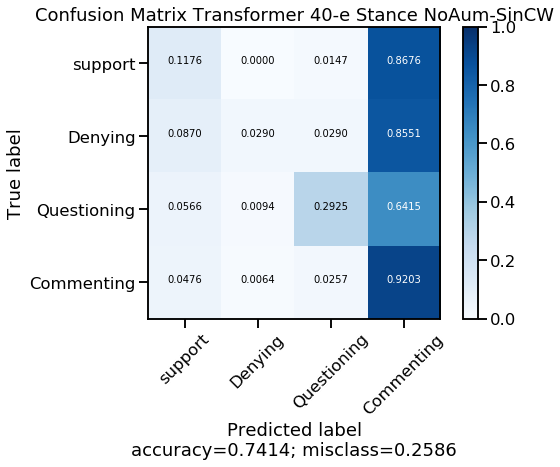

Encoder Layer Attention head 0


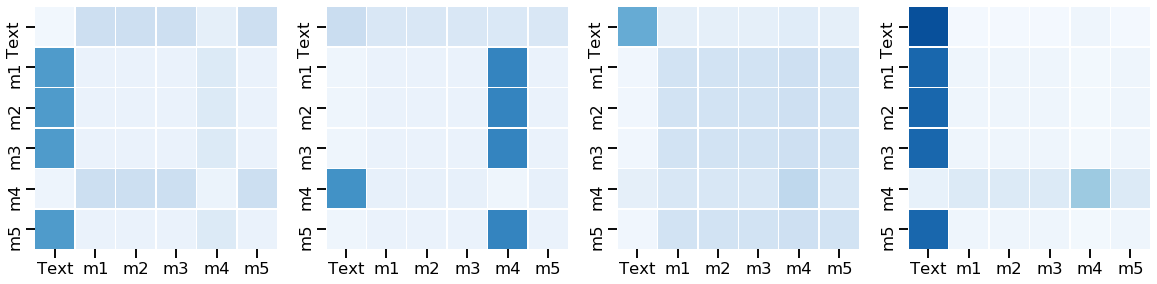

Encoder Layer Attention head 1


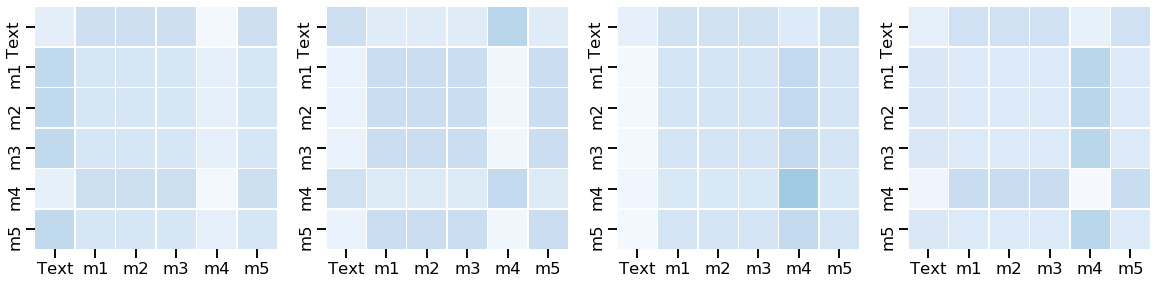

Entrenando Run # 2
Pesos de clases: [1.0, 1.0, 1.0, 1.0]
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.3056, dtype=torch.float64) 	F-macro_val: tensor(0.2055, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.7014, dtype=torch.float64) 	F-macro_val: tensor(0.3982, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.7014, dtype=torch.float64) 	F-macro_val: tensor(0.4435, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.7222, dtype=torch.float64) 	F-macro_val: tensor(0.4824, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.7118, dtype=torch.float64) 	F-macro_val: tensor(0.4371, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.7153, dtype=torch.float64) 	F-macro_val: tensor(0.4722, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.7153, dtype=torch.float64) 	F-macro_val: tensor(0.4476, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.7153, dtype=torch.float64) 	F-macro_val: tensor(0.4581, dtype=torch.float64)
Epoch 8 	acc_val: tensor(0.7188, dtype=torch.float64

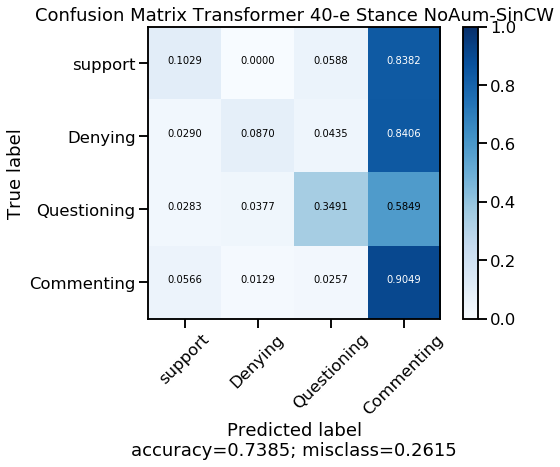

Encoder Layer Attention head 0


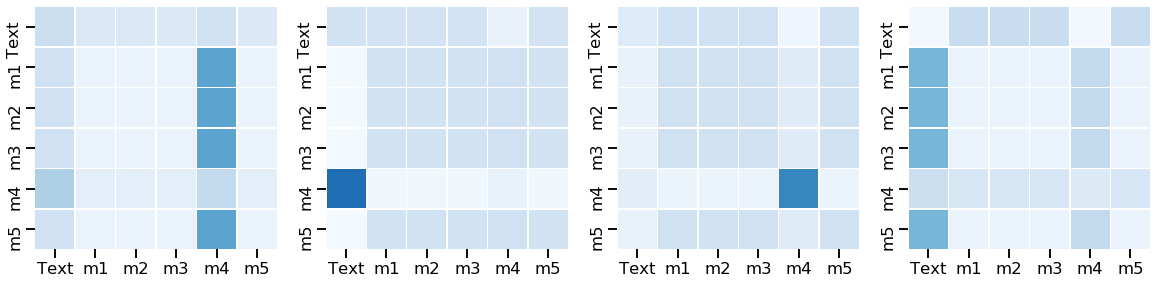

Encoder Layer Attention head 1


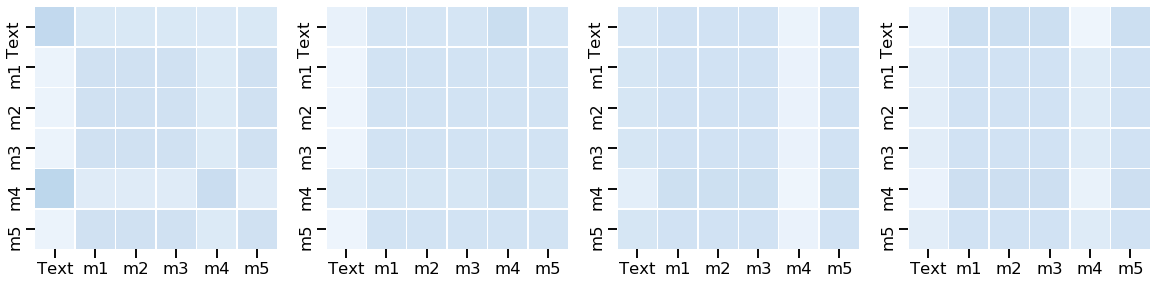

Entrenando Run # 3
Pesos de clases: [1.0, 1.0, 1.0, 1.0]
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.4965, dtype=torch.float64) 	F-macro_val: tensor(0.2350, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.6424, dtype=torch.float64) 	F-macro_val: tensor(0.3159, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.6667, dtype=torch.float64) 	F-macro_val: tensor(0.3857, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.6632, dtype=torch.float64) 	F-macro_val: tensor(0.3785, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.6597, dtype=torch.float64) 	F-macro_val: tensor(0.3906, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.6562, dtype=torch.float64) 	F-macro_val: tensor(0.4036, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.6493, dtype=torch.float64) 	F-macro_val: tensor(0.3892, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.6736, dtype=torch.float64) 	F-macro_val: tensor(0.4044, dtype=torch.float64)
Epoch 8 	acc_val: tensor(0.6632, dtype=torch.float64

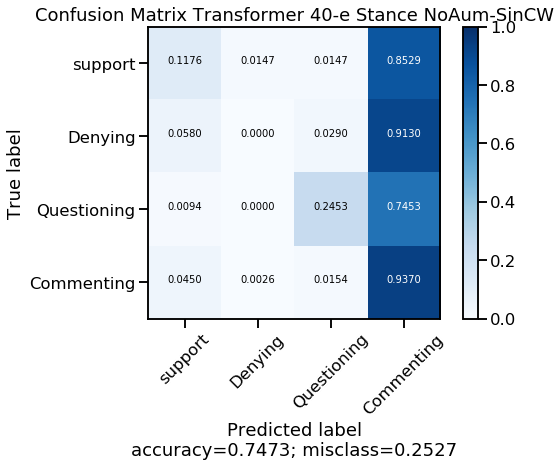

Encoder Layer Attention head 0


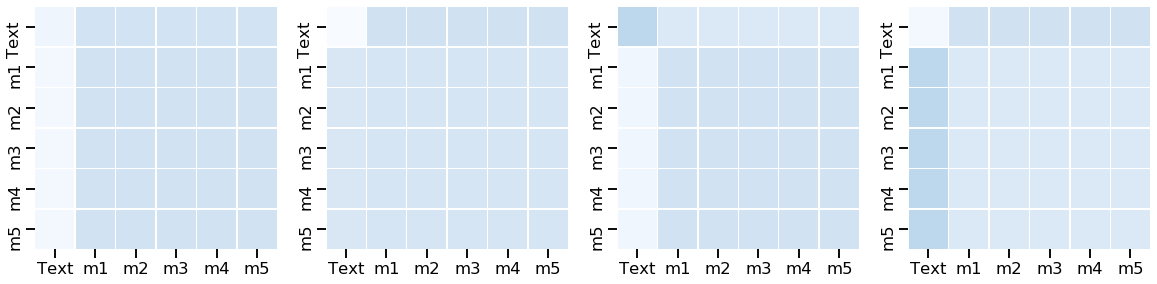

Encoder Layer Attention head 1


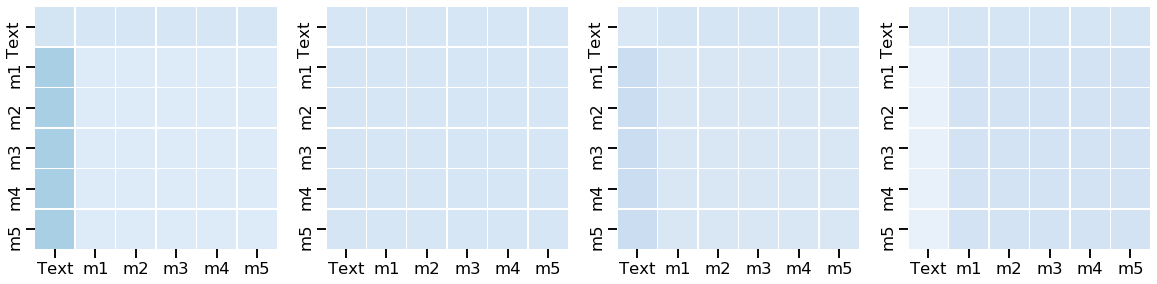

Entrenando Run # 4
Pesos de clases: [1.0, 1.0, 1.0, 1.0]
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.5694, dtype=torch.float64) 	F-macro_val: tensor(0.3077, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.6736, dtype=torch.float64) 	F-macro_val: tensor(0.3211, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.6979, dtype=torch.float64) 	F-macro_val: tensor(0.4060, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.7014, dtype=torch.float64) 	F-macro_val: tensor(0.3976, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.6875, dtype=torch.float64) 	F-macro_val: tensor(0.3810, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.7049, dtype=torch.float64) 	F-macro_val: tensor(0.3988, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.7014, dtype=torch.float64) 	F-macro_val: tensor(0.4266, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.6875, dtype=torch.float64) 	F-macro_val: tensor(0.3898, dtype=torch.float64)
Epoch 8 	acc_val: tensor(0.6979, dtype=torch.float64

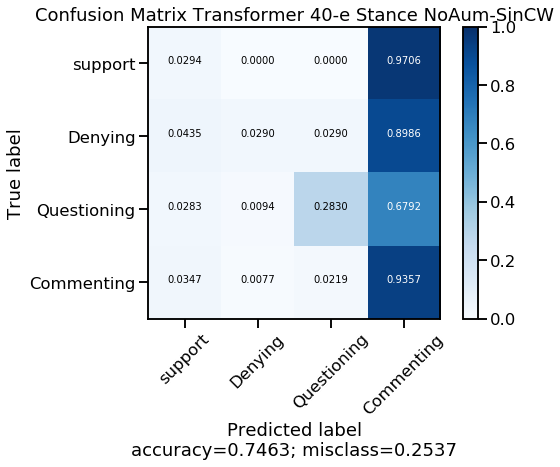

Encoder Layer Attention head 0


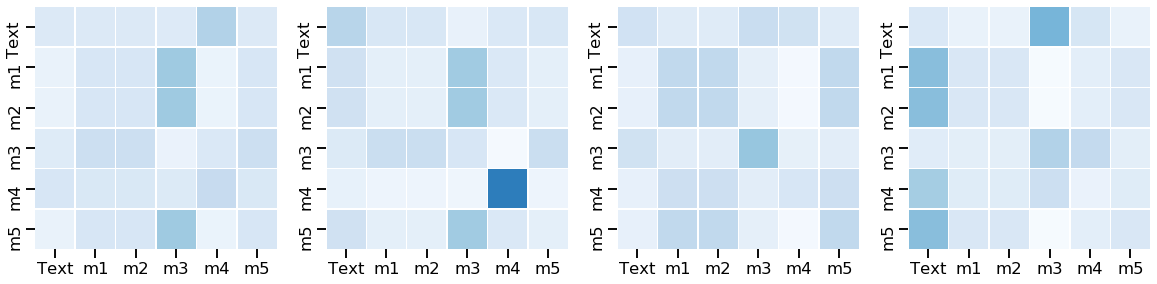

Encoder Layer Attention head 1


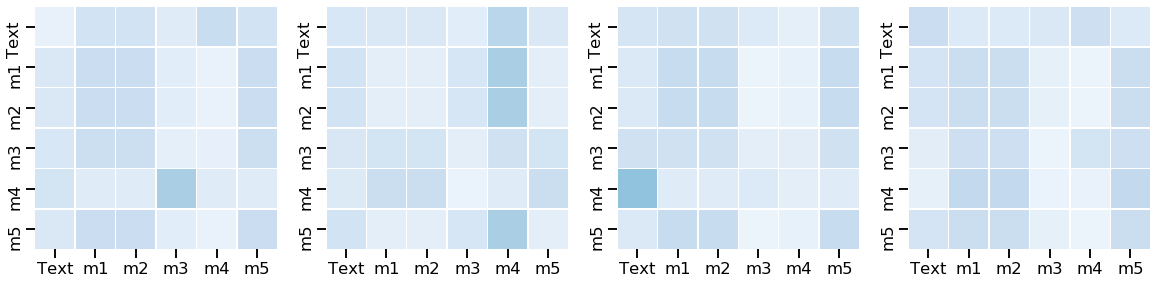

Entrenando Run # 5
Pesos de clases: [1.0, 1.0, 1.0, 1.0]
tensor([1., 1., 1., 1.])
Creando modelo con salida Softmax
Epoch 0 	acc_val: tensor(0.4514, dtype=torch.float64) 	F-macro_val: tensor(0.3279, dtype=torch.float64)
Epoch 1 	acc_val: tensor(0.6319, dtype=torch.float64) 	F-macro_val: tensor(0.2783, dtype=torch.float64)
Epoch 2 	acc_val: tensor(0.6493, dtype=torch.float64) 	F-macro_val: tensor(0.3580, dtype=torch.float64)
Epoch 3 	acc_val: tensor(0.6667, dtype=torch.float64) 	F-macro_val: tensor(0.3927, dtype=torch.float64)
Epoch 4 	acc_val: tensor(0.6736, dtype=torch.float64) 	F-macro_val: tensor(0.3859, dtype=torch.float64)
Epoch 5 	acc_val: tensor(0.6701, dtype=torch.float64) 	F-macro_val: tensor(0.3880, dtype=torch.float64)
Epoch 6 	acc_val: tensor(0.6840, dtype=torch.float64) 	F-macro_val: tensor(0.4229, dtype=torch.float64)
Epoch 7 	acc_val: tensor(0.6875, dtype=torch.float64) 	F-macro_val: tensor(0.4389, dtype=torch.float64)
Epoch 8 	acc_val: tensor(0.6944, dtype=torch.float64

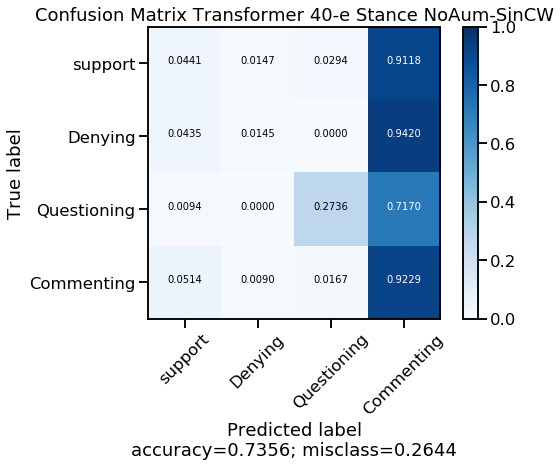

Encoder Layer Attention head 0


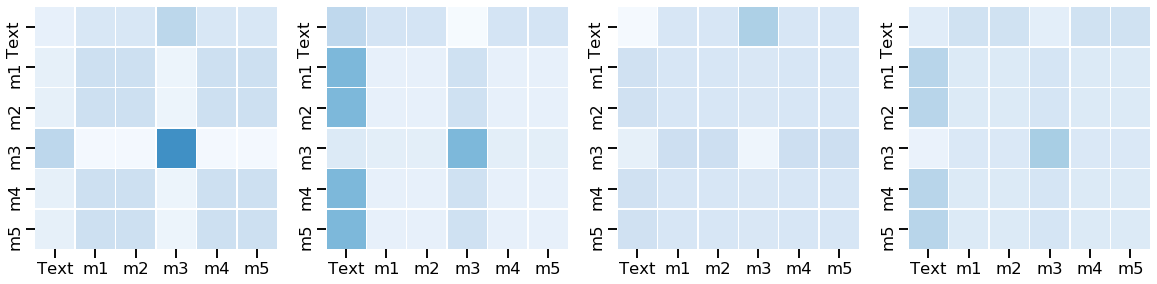

Encoder Layer Attention head 1


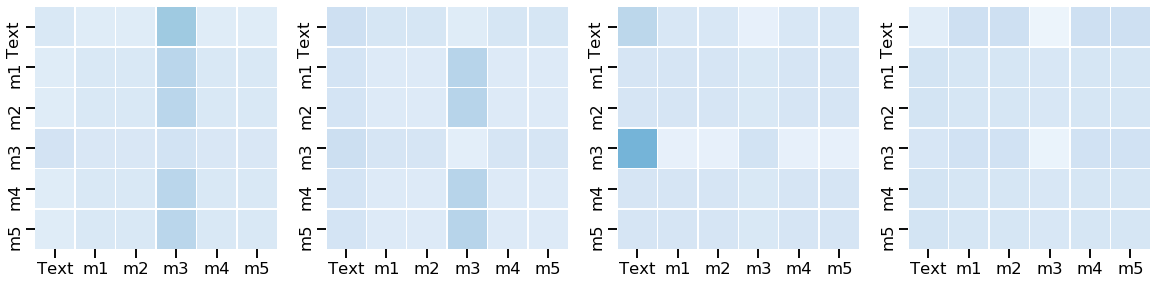

In [3]:
for trans in range(1,6): 
    print ("Entrenando Run #", trans)
    tokenizer_loaded = BertTokenizer.from_pretrained(dir_path)#'bert-base-uncased')
    model_loaded = BertForSequenceClassification.from_pretrained(dir_path, num_labels=4)#'bert-base-uncased',  num_labels=4) 
    idx_2_token = tokenizer_loaded.ids_to_tokens
    archivo = open(dir_path+'vocab.txt','r')
    Word2Index={word.strip():i for i,word in enumerate(archivo.readlines())}
    M_BERT_space = model_loaded.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
    transformer = Normalizer().fit(M_BERT_space) 
    M_BERT_space=transformer.transform(M_BERT_space)
    macro_augmented= np.load('../Data_augmented/Stance_agregado/Sin_Aumento_'+str(trans)+'-run_0.0_balanced_w4_app1_Top1.npy', allow_pickle=True)

    ids_train=macro_augmented[:,0]
    tws_train=macro_augmented[:,1]
    labels_train=macro_augmented[:,2]
    #class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train) #[1.0, 1.0, 1.0, 1.0] #
    class_weights= [1.0, 1.0, 1.0, 1.0]
    print ("Pesos de clases:", class_weights)

    etiq=labels_train.copy()
    sentences = tws_train
    n_labels = np.array(etiq)
    input_ids = []
    for sent in sentences:
        encoded_sent = tokenizer_loaded.encode(list(sent),add_special_tokens = False)    
        input_ids.append(encoded_sent)
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                              value=0, truncating="post", padding="post")
    y_train=to_categorical(n_labels,num_classes=4)
    shape=np.asarray(input_ids).shape
    x_train=np.zeros((shape[0], shape[1], 768))
    j=0
    for in_id in input_ids:
        x_train[j]=M_BERT_space[in_id]
        j+=1


    cnn1 = load_model('../Operador_Data_Augmentation/exec_baselines/0.0_wo/cnn1_'+str(trans)+'-exec_w4_app1_Top_0.0_1.h5')
    cnn2 = load_model('../Operador_Data_Augmentation/exec_baselines/0.0_wo/cnn2_'+str(trans)+'-exec_w4_app1_Top_0.0_1.h5')
    rnn1 = load_model('../Operador_Data_Augmentation/exec_baselines/0.0_wo/rnn1_'+str(trans)+'-exec_w4_app1_Top_0.0_1.h5')
    rnn2 = load_model('../Operador_Data_Augmentation/exec_baselines/0.0_wo/rnn2_'+str(trans)+'-exec_w4_app1_Top_0.0_1.h5')
    rnn3 = load_model('../Operador_Data_Augmentation/exec_baselines/0.0_wo/rnn3_'+str(trans)+'-exec_w4_app1_Top_0.0_1.h5')
    
    list_models=['cnn1', 'cnn2', 'rnn1', 'rnn2', 'rnn3']
    index_models=np.arange(5)
    dict_models=dict((key, value) for (key, value) in zip(index_models,list_models))
    modelos=[cnn1, cnn2, rnn1, rnn2, rnn3]
    ind=np.arange(5)
    dict_trainedModel=dict((key, value) for (key, value) in zip(ind,modelos))

    bs=32
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]

    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all.append(dict_trainedModel[i].predict(x_train, batch_size=bs))
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_val.append(dict_trainedModel[i].predict(x_val, batch_size=bs))
    for i in dict_trainedModel.keys(): 
        a_evaluar=dict_models[i]
        predicciones_all_test.append(dict_trainedModel[i].predict(x_test, batch_size=bs))

    matrix=np.asarray(predicciones_all)
    matrix_val=np.asarray(predicciones_all_val)
    matrix_test=np.asarray(predicciones_all_test)
    new_matrix=np.concatenate([matrix,matrix_val,matrix_test], axis=1)

    fromId2num={}
    keys=list(ids_train)+list(val['Tw_id'])+list(test['Tw_id'])
    values=np.arange(5,len(keys)+5)
    for key, value in list(zip(keys,values)):
        fromId2num[key]=value   #original largo --> valor tabla (index)

    fromNum2Id={}
    for value, key in list(zip(values,keys)):
        fromNum2Id[value]=key   #valor tabla (index) --> original largo

    espacio=[np.ones(768)]
    Ks=np.load("../../../BERTransformer/Orthogonals_768.npy")
    random=np.random.randint(Ks.shape[0], size=4)
    K_list=Ks[random]
    K_list_ext=espacio+list(K_list)
    objs_train=ids_train.copy()
    objs_val=val['Tw_id']      #df_val['Unnamed: 0'].values
    objs_test=test['Tw_id']    #np.arange(df_test.shape[0])
    llaves=np.concatenate([objs_train,objs_val,objs_test])

    K_list_new=K_list_ext
    for i in llaves:
        vector=np.load("../../BERTasService/Original/"+str(i)+".npy")
        norm=np.linalg.norm(vector)
        vector= vector / norm
        K_list_new.append(vector)

    K_list_new= np.asarray(K_list_new, dtype='float32')
    K_list_new.shape 

    del tokenizer_loaded 
    del model_loaded 
    del idx_2_token 
    del M_BERT_space

    ###
    class_weights=np.asarray(class_weights)
    ############################################# TRANSFORMER ##########################################

    V = 4
    pesos = torch.from_numpy(class_weights).float()
    print (pesos)
    criterion = FocalLoss(weights=pesos)
    model = make_model_concat(4, N=2,d_model=768, d_ff=128, h=4, dropout=0.35)
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 500, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))

    hist_train_loss=[]
    hist_train_acc=[]
    hist_train_fma=[]
    hist_val_loss=[]
    hist_val_acc=[]
    hist_val_fma=[]

    for epoch in range(40):
        model.train()
        DATA=data_gen(bs, 'Train', 5, new_matrix)
        loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

        model.eval()
        loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(data_gen(bs, 'Val', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Val')
        print ("Epoch",epoch, "\tacc_val:",acc_val, "\tF-macro_val:",fma_val)

    model.eval()
    print ("Testing run #",trans)
    predicciones = run_epoch(data_gen(bs, 'Test', 5, new_matrix), model, SimpleLossComputeFL(criterion, None),'Test')
    predicciones=np.concatenate(predicciones, axis=-1)

    glo_acc=accuracy_score(etiq_t, predicciones[:-3])
    glo_fno=f1_score(etiq_t,predicciones[:-3], average=None)
    glo_fma=f1_score(etiq_t,predicciones[:-3], average='macro')

    print("Test_ acc:",glo_acc) 
    print("Test_ f1 none:",glo_fno) 
    print("Test_ f1 macro:",glo_fma) 

    glo_cm=confusion_matrix(etiq_t, predicciones[:-3])
    plot_confusion_matrix(glo_cm,["support","Denying","Questioning","Commenting"],"Confusion Matrix Transformer 40-e Stance NoAum-SinCW")
    global_accs.append(glo_acc)
    global_fnones.append(glo_fno)
    global_fmacros.append(glo_fma)
    global_cms.append(glo_cm)

    label=[['Text', 'm1', 'm2','m3','m4','m5']]
    for layer in range(2):
        fig, axs = plt.subplots(1,4, figsize=(20, 10))
        print ("Encoder Layer Attention head", layer)
        for head in range(4):
            matriz_attn=model.encoder.layers[layer].self_attn.attn[0,head].data
            dict_attn_enc[str(layer)+str(head)].append(matriz_attn)
            sns.heatmap(matriz_attn, xticklabels=label[0], yticklabels=label[0],
                        vmin=0.0, vmax=1.0, linewidths=.5, cmap="Blues", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
        plt.show()

## Comportamiento Global promedio

In [4]:
np.mean(np.asarray(global_accs))

0.7418217433888344

In [5]:
np.mean(np.asarray(global_fmacros))

0.34688606279635603

In [6]:
global_fnones

[array([0.128     , 0.05194805, 0.3875    , 0.85238095]),
 array([0.11290323, 0.13483146, 0.43529412, 0.84870404]),
 array([0.13793103, 0.        , 0.3537415 , 0.85413005]),
 array([0.03883495, 0.05128205, 0.38709677, 0.85345838]),
 array([0.05217391, 0.02564103, 0.38666667, 0.84520306])]

In [7]:
sup=np.mean(np.asarray(global_fnones)[:,0])
den=np.mean(np.asarray(global_fnones)[:,1])
que=np.mean(np.asarray(global_fnones)[:,2])
com=np.mean(np.asarray(global_fnones)[:,3])
print (sup,den,que,com)

0.09396862495779983 0.05274051790905724 0.3900598110211827 0.8507752972973842


In [8]:
m_temp=np.zeros((4,4))
for m in global_cms:
    #print ("matrix",m, np.asarray(m, dtype='int').shape)
    m_temp+=np.asarray(m)
    #print ("\nLa suma dio:", m_temp)
m_temp

array([[2.800e+01, 2.000e+00, 8.000e+00, 3.020e+02],
       [1.800e+01, 1.100e+01, 9.000e+00, 3.070e+02],
       [1.400e+01, 6.000e+00, 1.530e+02, 3.570e+02],
       [1.830e+02, 3.000e+01, 8.200e+01, 3.595e+03]])

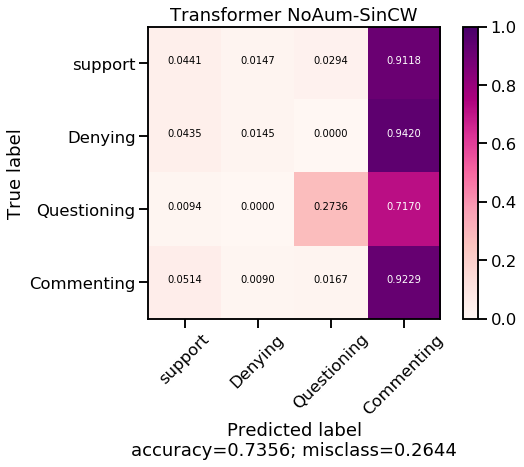

In [9]:
plot_confusion_matrix(glo_cm,["support","Denying","Questioning","Commenting"],"Transformer NoAum-SinCW", cmap='RdPu')


Encoder Layer Attention head Promedio 0


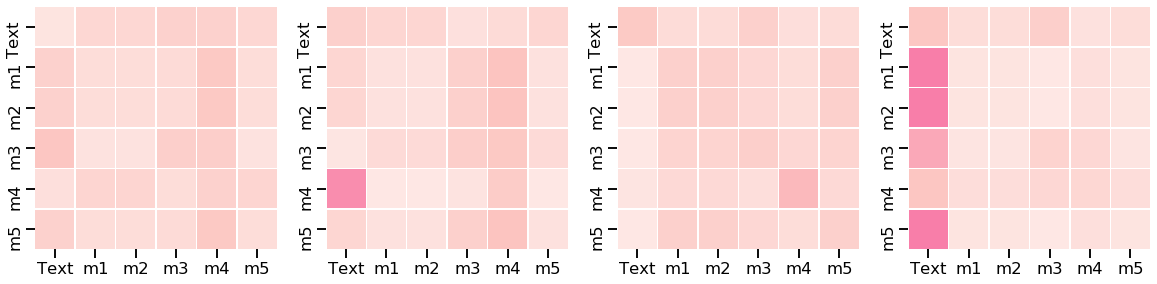

Encoder Layer Attention head Promedio 1


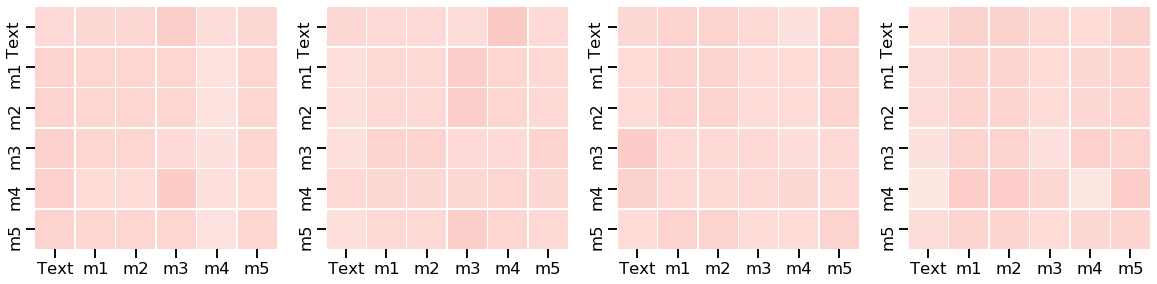

In [33]:
label=[['Text', 'm1', 'm2','m3','m4','m5']]
for layer in range(2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print ("Encoder Layer Attention head Promedio", layer)
    for head in range(4):
        at=np.zeros((6,6))
        matriz_attn= dict_attn_enc[str(layer)+str(head)]  #lista de 5 corridas en cada pos
        for m in matriz_attn:
            at+=m.numpy()
        sns.heatmap(at/5., xticklabels=label[0], yticklabels=label[0],
                    vmin=0.0, vmax=1.0, linewidths=.5, cmap="RdPu", cbar=False, square=True, ax=axs[head]) #, annot=False,cbar_kws={"orientation": "horizontal","pad": 0.25})
    plt.show()